In [1]:
import numpy as np
import random
import einops
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST, FashionMNIST
from torchvision.transforms import Compose, Lambda, ToTensor
from tqdm.auto import tqdm

def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:, ::2] = torch.sin(t * wk[:, ::2])
    embedding[:, 1::2] = torch.cos(t * wk[:, ::2])

    return embedding

# DDPM class
class MyDDPM(nn.Module):
    def __init__(
        self,
        network,
        n_steps=200,
        min_beta=10**-4,
        max_beta=0.02,
        device=None,
        image_chw=(1, 28, 28),
    ):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device
        )  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor(
            [torch.prod(self.alphas[: i + 1]) for i in range(len(self.alphas))]
        ).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = (
            a_bar.sqrt().reshape(n, 1, 1, 1) * x0
            + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        )
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)


class MyBlock(nn.Module):
    def __init__(
        self,
        shape,
        in_c,
        out_c,
        kernel_size=3,
        stride=1,
        padding=1,
        activation=None,
        normalize=True,
    ):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out


class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 28, 28), 1, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10),
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20),
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40),
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1), nn.SiLU(), nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40),
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1),
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20),
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10),
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False),
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(
            self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1)
        )  # (N, 20, 14, 14)
        out3 = self.b3(
            self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1)
        )  # (N, 40, 7, 7)

        out_mid = self.b_mid(
            self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1)
        )  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out), nn.LeakyReLU(), nn.Linear(dim_out, dim_out)
        )

Using device: cuda	NVIDIA RTX A5000


Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 1: 0.182 --> Best model ever (stored)


Epoch 2/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 2: 0.061 --> Best model ever (stored)


Epoch 3/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 3: 0.054 --> Best model ever (stored)


Epoch 4/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 4: 0.050 --> Best model ever (stored)


Epoch 5/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 5: 0.048 --> Best model ever (stored)


Epoch 6/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 6: 0.047 --> Best model ever (stored)


Epoch 7/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 7: 0.046 --> Best model ever (stored)


Epoch 8/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 8: 0.045 --> Best model ever (stored)


Epoch 9/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 9: 0.044 --> Best model ever (stored)


Epoch 10/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 10: 0.043 --> Best model ever (stored)


Epoch 11/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 11: 0.042 --> Best model ever (stored)


Epoch 12/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 12: 0.041 --> Best model ever (stored)


Epoch 13/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 13: 0.041 --> Best model ever (stored)


Epoch 14/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 14: 0.042


Epoch 15/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 15: 0.040 --> Best model ever (stored)


Epoch 16/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 16: 0.040


Epoch 17/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 17: 0.040 --> Best model ever (stored)


Epoch 18/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 18: 0.039 --> Best model ever (stored)


Epoch 19/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 19: 0.039 --> Best model ever (stored)


Epoch 20/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 20: 0.039 --> Best model ever (stored)
Model loaded: Generating new images


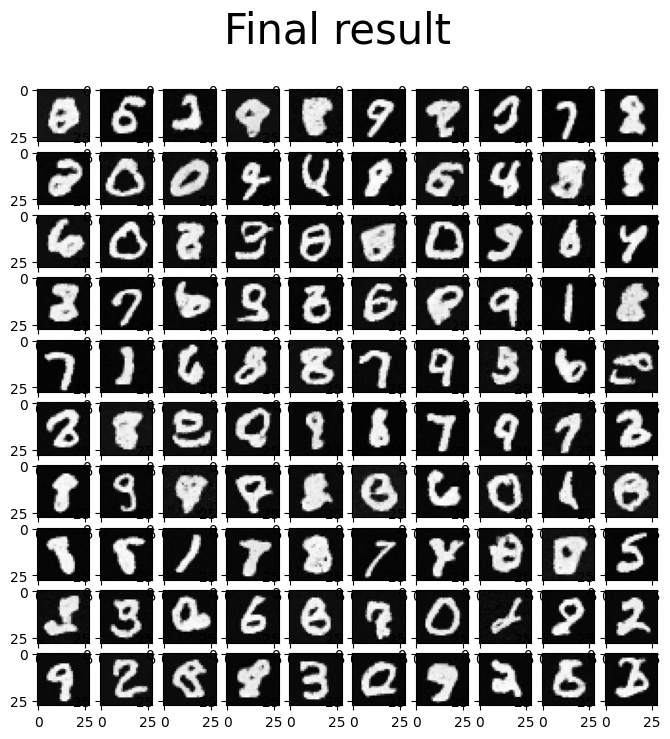

In [2]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

STORE_PATH_MNIST = f"ddpm_model_mnist.pt"

def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    idx = 0
    for _ in range(rows):
        for _ in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)
    plt.show()


def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break


def show_forward(ddpm, loader, device):
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(
                    imgs.to(device),
                    [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))],
                ),
                f"DDPM Noisy images {int(percent * 100)}%",
            )
        break


def generate_new_images(
    ddpm,
    n_samples=16,
    device=None,
    frames_per_gif=100,
    gif_name="sampling.gif",
    c=1,
    h=28,
    w=28,
):
    # Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
    
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]
            x = (1 / alpha_t.sqrt()) * (
                x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta
            )

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()
                x = x + sigma_t * z

            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                frame = einops.rearrange(
                    normalized,
                    "(b1 b2) c h w -> (b1 h) (b2 w) c",
                    b1=int(n_samples**0.5),
                )
                frame = frame.cpu().numpy().astype(np.uint8)
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            rgb_frame = np.repeat(frame, 3, axis=2)
            writer.append_data(rgb_frame)

            # Showing the last frame for a longer time
            if idx == len(frames) - 1:
                last_rgb_frame = np.repeat(frames[-1], 3, axis=2)
                for _ in range(frames_per_gif // 3):
                    writer.append_data(last_rgb_frame)
    return x


def training_loop(
    ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"
):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(
            tqdm(
                loader,
                leave=False,
                desc=f"Epoch {epoch + 1}/{n_epochs}",
                colour="#005500",
            )
        ):
            # Load
            x0 = batch[0].to(device)
            n = len(x0)

            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Getting noisy images
            noisy_imgs = ddpm(x0, t, eta)

            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        if display:
            show_images(
                generate_new_images(ddpm, device=device),
                f"Images generated at epoch {epoch + 1}",
            )

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

bs = 128
n_epochs = 20
lr = 0.001

store_path = "ddpm_mnist.pt"

transform = Compose([ToTensor(), Lambda(lambda x: (x - 0.5) * 2)])
ds_fn = MNIST 
dataset = ds_fn("./../datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, bs, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(
    f"Using device: {device}\t"
    + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU")
)

# Model
n_steps, min_beta, max_beta = 1000, 10**-4, 0.01  
ddpm = MyDDPM(
    MyUNet(n_steps),
    n_steps=n_steps,
    min_beta=min_beta,
    max_beta=max_beta,
    device=device,
)
# Training
training_loop(
    ddpm,
    loader,
    n_epochs,
    optim=Adam(ddpm.parameters(), lr),
    device=device,
    store_path=store_path,
)

best_model = MyDDPM(MyUNet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded: Generating new images")

generated = generate_new_images(
    best_model,
    n_samples=100,
    device=device,
    gif_name= "mnist.gif",
)
show_images(generated, "Final result")
